In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from ggplot import *
import time

In [2]:
data_path = '../../../'
loans_full = pd.read_csv(data_path+"/loans_full.csv", index_col=0)
loans_details = pd.read_csv(data_path+"/loans_details.csv", index_col=0)
additional_columns =  loans_full.columns.difference(loans_details.columns).tolist() + ['id']
df = loans_details.merge(loans_full[['id', 'borrower_count']], left_on='id', right_on='id')

/Users/j/virtualenvs/delta/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (21,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/j/virtualenvs/delta/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (8,9,10,29,42,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loans_details['loan-funded'] = loans_details['loan_amount'] - loans_details['funded_amount']

In [4]:
df['male'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]=='M')
df['num_borrowers'] = df['borrowers'].apply(lambda x: len([y for y in x if y=='}']))
# convert strs to datetimes
for col in df.columns:
    if "_date" in col:
        df[col] = pd.to_datetime(df[col])
        col_root = col.split('_date')[0]
        df[col_root+"_year"] = df[col].apply(lambda x: x.year)
        df[col_root+"_month"] = df[col].apply(lambda x: x.month)
        df[col_root+"_unix"] = df[col].apply(lambda x: time.mktime(x.timetuple()) if not pd.isnull(x) else 0)
        

In [5]:
df['lat'] = df['location.geo.pairs'].apply(lambda x: x.split()[0])
df['long'] = df['location.geo.pairs'].apply(lambda x: x.split()[1])

/Users/j/virtualenvs/delta/lib/python3.6/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


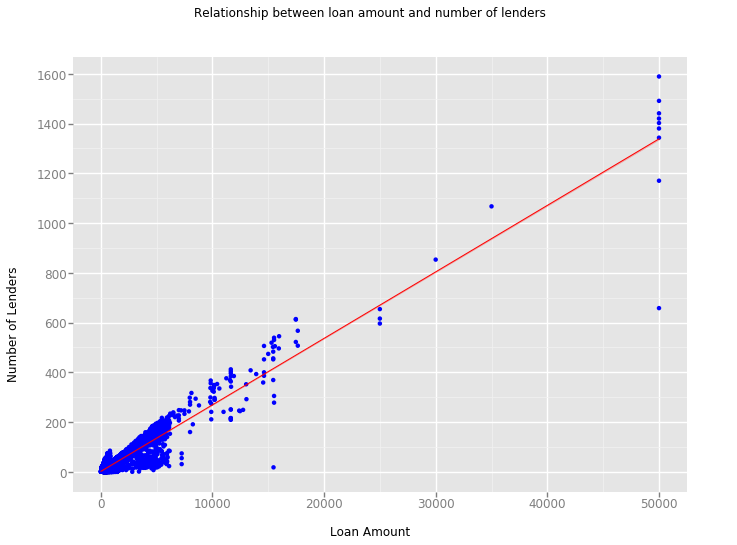

<ggplot: (295030455)>

In [6]:
ggplot(df , aes(x = 'loan_amount', y = 'lender_count')) + geom_point(color = "blue") + \
ggtitle("Relationship between loan amount and number of lenders") + xlab("Loan Amount") + ylab("Number of Lenders") + stat_smooth(color='red')

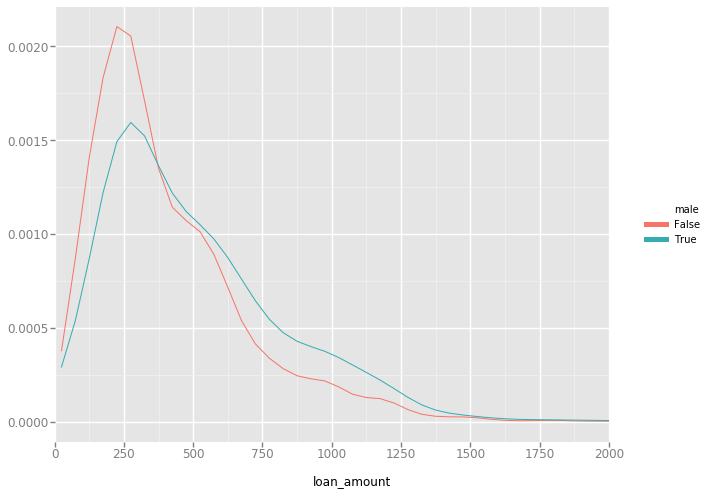

<ggplot: (-9223372036572164057)>

In [7]:
df['male'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]=='M')
ggplot(df, aes(x='loan_amount',colour='male')) + geom_density() + xlim(0,2000)

In [8]:
# get subset of data that is numeric
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(include=numerics).columns 

Index(['basket_amount', 'currency_exchange_loss_amount', 'funded_amount', 'id',
       'image.id', 'image.template_id', 'journal_totals.bulkEntries',
       'journal_totals.entries', 'lender_count', 'loan_amount', 'partner_id',
       'terms.disbursal_amount', 'terms.loan_amount',
       'terms.loss_liability.currency_exchange_coverage_rate',
       'terms.repayment_term', 'translator.image', 'video.id',
       'video.thumbnailImageId', 'borrower_count', 'num_borrowers',
       'funded_year', 'funded_month', 'funded_unix', 'planned_expiration_year',
       'planned_expiration_month', 'planned_expiration_unix', 'posted_year',
       'posted_month', 'posted_unix', 'terms.disbursal_year',
       'terms.disbursal_month', 'terms.disbursal_unix'],
      dtype='object')

In [9]:
df[df['male']==True]['loan_amount'].describe()

count    40071.000000
mean       553.392728
std        791.894280
min         25.000000
25%        250.000000
50%        425.000000
75%        675.000000
max      50000.000000
Name: loan_amount, dtype: float64

In [10]:
df[df['male']==False]['loan_amount'].describe()

count    87887.000000
mean       435.296460
std        622.751428
min         25.000000
25%        225.000000
50%        325.000000
75%        550.000000
max      50000.000000
Name: loan_amount, dtype: float64

In [11]:
female_df = df[(df['male']==False) & (pd.notnull(df['funded_date'])) & (pd.notnull(df['funded_amount']))]
male_df = df[(df['male']==True) & (pd.notnull(df['funded_date'])) & (pd.notnull(df['funded_amount']))]

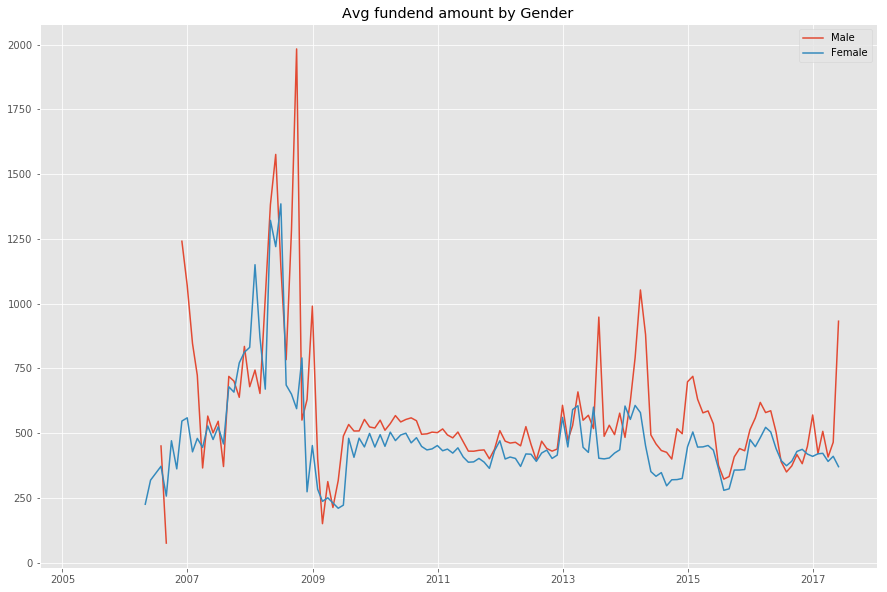

In [12]:
male_df.index = male_df['funded_date']
female_df.index = female_df['funded_date']
resampled_male_df = male_df.resample('M').mean()
resampled_female_df = female_df.resample('M').mean()
plt.rcParams['figure.figsize'] = (15, 10)
plt.plot(resampled_male_df['funded_amount'],label='Male')
plt.plot(resampled_female_df['funded_amount'],label='Female')
plt.title("Avg fundend amount by Gender")
plt.legend()
plt.show()

In [13]:
X = df[['lat','long','funded_unix','num_borrowers','male', 'activity', 'location.town', 'partner_id', "sector", "tags", "loan_amount"]]
rf_X = X.copy()
rf_X = rf_X.dropna()
y = rf_X['loan_amount']
rf_X = rf_X.drop("loan_amount", axis=1)
rf_X.columns

for col in X.columns[:-1]:
    if col not in ['male', 'num_borrowers', 'funded_unix','lat','long', 'lender_count']:
        if col=='tags':
            col_vals = ["#Woman Owned Biz", "#Parent", "user_favorite", "#Repeat Borrower", "volunteer_pick", "#Vegan", "volunteer_like","#Animals", "#Eco-friendly", "#Technology"]
        else:
            col_vals = X[col].value_counts().index[:10]
            
        for col_val in col_vals:
            if col_val not in rf_X.columns:
                rf_X[col+"_"+str(col_val)] = X[col]==col_val
            else:
                print(col, col_val)
        rf_X = rf_X.drop(col, axis=1)
    else:
        pass
rf = RandomForestRegressor(n_estimators=100, oob_score=True)
rf.fit(rf_X,y)
rf.oob_score_

0.38292215981828015

In [14]:
# X['location.town'].value_counts()
# sub_df = X[(X['location.town']=="Likoni")&(X['num_borrowers']==1)&(X['funded_year']==2013)]
# for sect in sub_df['sector'].value_counts().index[:10]:
#     sub_df2 = sub_df[(sub_df['sector']==sect)&(sub_df['num_borrowers']==1)]
#     print(sect)
#     print("male: \t\t"+str(sub_df2[sub_df2['male']==True]['loan_amount'].mean()))
#     print("female: \t"+str(sub_df2[sub_df2['male']==False]['loan_amount'].mean()))
    
    
# for sect in X['sector'].value_counts().index[:10]:
#     sub_df1 = X[(X['sector']==sect)]
#     sub_df2 = X[(X['sector']==sect)&(X['num_borrowers']==1)]
#     print(sect, "\t\t all obs \t\t 1 obs")
#     print("male: \t\t"+str(sub_df1[sub_df1['male']==True]['loan_amount'].mean())+"\t\t"+str(sub_df2[sub_df2['male']==True]['loan_amount'].mean()))
#     print("female: \t"+str(sub_df1[sub_df1['male']==False]['loan_amount'].mean())+"\t\t"+str(sub_df2[sub_df2['male']==False]['loan_amount'].mean()))
    
# sub_df = X[X['sector']=='Education']
# print(sub_df[sub_df['male']==True]['loan_amount'].describe())
# print(sub_df[sub_df['male']==False]['loan_amount'].describe())


for sect in X['sector'].value_counts().index[:10]:
    sub_df1 = X[(X['sector']==sect)]
    sub_df2 = X[(X['sector']==sect)&(X['num_borrowers']==1)]
    print(sect, "\t\t all obs \t\t 1 obs")
    print("male: \t\t"+str(sub_df1[sub_df1['male']==True]['loan_amount'].mean())+"\t\t"+str(sub_df2[sub_df2['male']==True]['loan_amount'].mean()))
    print("female: \t"+str(sub_df1[sub_df1['male']==False]['loan_amount'].mean())+"\t\t"+str(sub_df2[sub_df2['male']==False]['loan_amount'].mean()))
    
    
    
    

Agriculture 		 all obs 		 1 obs
male: 		608.381924198		466.334495602
female: 	513.743051266		397.042684249
Food 		 all obs 		 1 obs
male: 		440.802455602		436.430304367
female: 	352.246169236		350.083585234
Retail 		 all obs 		 1 obs
male: 		526.840277778		517.023346304
female: 	430.816719529		425.041888804
Services 		 all obs 		 1 obs
male: 		466.511357018		465.096547689
female: 	383.983388704		380.757129468
Clothing 		 all obs 		 1 obs
male: 		455.040770941		453.60612855
female: 	378.834140745		374.829603909
Transportation 		 all obs 		 1 obs
male: 		504.899691358		502.283281734
female: 	488.06156406		487.896494157
Personal Use 		 all obs 		 1 obs
male: 		302.425665102		228.855325914
female: 	220.118771727		181.465517241
Construction 		 all obs 		 1 obs
male: 		438.716108453		437.090327738
female: 	402.336448598		401.844583987
Education 		 all obs 		 1 obs
male: 		1372.62544803		1372.62544803
female: 	659.941176471		657.600157109
Health 		 all obs 		 1 obs
male: 		1029.71092077		684.

In [15]:
# Create 1 hot encodings
X = df[['loan_amount','lat','long','funded_unix','funded_month', 'num_borrowers','male', 'activity', 'location.town', 'partner_id', "sector", "tags"]]
rf_X = X.copy()
rf_X = rf_X.dropna()
y = rf_X['male']
rf_X = rf_X.drop("male", axis=1)
X.columns

for col in X.columns:
    if col not in ['male','loan_amount','num_borrowers','lat','long','funded_unix','funded_month','lender_count']:
        if col=='tags':
            col_vals = ["#Parent", "user_favorite", "#Repeat Borrower", "volunteer_pick", "#Vegan", "volunteer_like","#Animals", "#Eco-friendly", "#Technology"]
        else:
            col_vals = X[col].value_counts().index[:10]
            
        for col_val in col_vals:
            if col_val not in rf_X.columns:
                rf_X[col+"_"+str(col_val)] = X[col]==col_val
            else:
                print(col, col_val)
        rf_X = rf_X.drop(col, axis=1)
    else:
        pass

In [16]:
# Predict gender based on loan stats.
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf.fit(rf_X,y)
rf.oob_score_

0.72653613711322518

In [17]:
df[df['partner_id']==164]['male'].describe()

count     21570
unique        2
top       False
freq      19350
Name: male, dtype: object

In [18]:
# Print Feature importances.
# Results show that time trends are the most important, followed by amount funded. Very Strange that month makes the list
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, rf_X.columns[indices[f]], importances[indices[f]]))


Feature ranking:
1. feature funded_unix (0.461827)
2. feature loan_amount (0.164846)
3. feature funded_month (0.114248)
4. feature sector_Transportation (0.032614)
5. feature partner_id_164.0 (0.030678)
6. feature lat (0.020659)
7. feature long (0.020204)
8. feature num_borrowers (0.015121)
9. feature sector_Food (0.013746)
10. feature partner_id_133.0 (0.013332)
11. feature sector_Construction (0.007508)
12. feature sector_Clothing (0.007376)


In [19]:
df[pd.isnull(df['funded_date'])]['posted_year'].value_counts()

2016    1931
2017    1338
2015    1299
2014     503
2012     354
2013     202
Name: posted_year, dtype: int64

/Users/j/virtualenvs/delta/lib/python3.6/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


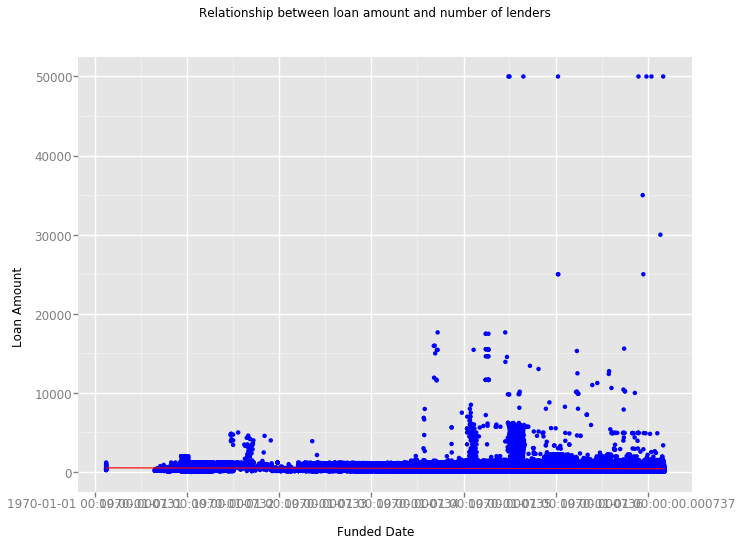

<ggplot: (-9223372036571307639)>

In [20]:
to_plot = df[['funded_date', 'loan_amount']].dropna()
ggplot(to_plot , aes(x = 'funded_date', y = 'loan_amount')) + geom_point(color = "blue") + \
ggtitle("Relationship between loan amount and number of lenders") + xlab("Funded Date") + ylab("Loan Amount") + stat_smooth(color='red')

In [21]:
df['funded_date'].dropna().apply(lambda x: time.mktime(x.timetuple()))

16        1.494315e+09
21        1.494310e+09
26        1.494307e+09
47        1.494288e+09
48        1.494279e+09
50        1.494282e+09
51        1.494288e+09
53        1.494308e+09
54        1.494280e+09
55        1.494270e+09
56        1.494265e+09
61        1.494224e+09
62        1.494229e+09
64        1.494223e+09
65        1.494230e+09
67        1.494281e+09
68        1.494220e+09
73        1.494221e+09
86        1.494303e+09
88        1.494223e+09
90        1.494214e+09
91        1.494218e+09
93        1.494216e+09
94        1.494218e+09
95        1.494225e+09
98        1.494219e+09
99        1.494301e+09
100       1.494299e+09
101       1.494209e+09
102       1.494208e+09
              ...     
127928    1.149728e+09
127929    1.148104e+09
127930    1.148277e+09
127931    1.148100e+09
127932    1.148389e+09
127933    1.148194e+09
127934    1.147952e+09
127935    1.148234e+09
127936    1.147913e+09
127937    1.147933e+09
127938    1.149301e+09
127939    1.112279e+09
127940    1

In [22]:
df['children'] = df['description.texts.en'].apply(lambda x: "CHILDREN" in x.upper() if type(x)==str else 0)

In [23]:
percent_female = []
percent_of_male_avg = []
parnter_id = []
partner_obs = []
partner_children = []
for partner in df['partner_id'].value_counts().index:
    sub_df = df[df['partner_id']==partner]
    percent_female.append(sub_df[sub_df['male']==False].shape[0] / sub_df.shape[0])
    percent_of_male_avg.append(sub_df[sub_df['male']==False]['loan_amount'].mean()/sub_df[sub_df['male']==True]['loan_amount'].mean())
    parnter_id.append(partner)
    partner_obs.append(sub_df.shape[0])
    partner_children.append(sub_df[sub_df['children']==True].shape[0] / sub_df.shape[0])
#     print("Percent Female:" + str(percent_of_male_avg[-1])
#     print("male: \t\t"+str(sub_df[sub_df['male']==True]['loan_amount'].mean()))
#     print("female: \t"+str(sub_df[sub_df['male']==False]['loan_amount'].mean()))    

/Users/j/virtualenvs/delta/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


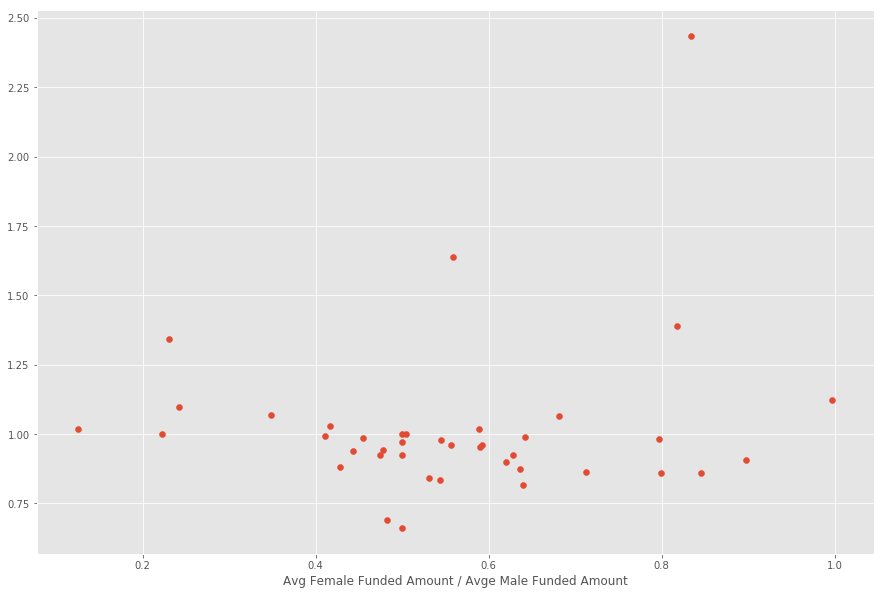

In [24]:
plt.scatter(percent_female, percent_of_male_avg)
plt.xlabel("Percent of Particapants Who are Female")
plt.xlabel("Avg Female Funded Amount / Avge Male Funded Amount")
plt.legend()
plt.show()

In [25]:
df['funded_ratio'] = df['funded_amount'] / df['loan_amount']
df[df['funded_ratio']<1].describe()

,basket_amount,currency_exchange_loss_amount,funded_amount,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,...,planned_expiration_year,planned_expiration_month,planned_expiration_unix,posted_year,posted_month,posted_unix,terms.disbursal_year,terms.disbursal_month,terms.disbursal_unix,funded_ratio
count,944.000000,0.0,5628.000000,5.628000e+03,5.628000e+03,5628.0,5628.0,5628.0,5628.000000,5628.000000,...,5627.000000,5627.000000,5.628000e+03,5628.000000,5628.000000,5.628000e+03,5613.000000,5613.000000,5.628000e+03,5628.000000
mean,0.185381,NaN,384.733475,1.008578e+06,2.055369e+06,1.0,0.0,0.0,10.136283,841.773276,...,2015.530123,6.429181,1.451952e+09,2015.467484,6.164890,1.449501e+09,2015.491894,5.497595,1.444778e+09,0.429526
std,2.145937,NaN,530.789697,2.357273e+05,3.823753e+05,0.0,0.0,0.0,14.100155,979.611132,...,1.340371,3.131282,4.554635e+07,1.372445,3.202845,4.143050e+07,1.350331,2.967249,8.540022e+07,0.268869
min,0.000000,NaN,0.000000,4.427600e+04,5.990510e+05,1.0,0.0,0.0,0.000000,75.000000,...,2012.000000,1.000000,0.000000e+00,2008.000000,1.000000,1.208582e+09,2008.000000,1.000000,0.000000e+00,0.000000
25%,0.000000,NaN,125.000000,8.739120e+05,1.861968e+06,1.0,0.0,0.0,4.000000,500.000000,...,2015.000000,5.000000,1.432786e+09,2015.000000,4.000000,1.430194e+09,2015.000000,3.000000,1.427724e+09,0.214286
50%,0.000000,NaN,275.000000,1.064937e+06,2.146865e+06,1.0,0.0,0.0,8.000000,700.000000,...,2016.000000,6.000000,1.465286e+09,2016.000000,5.000000,1.462263e+09,2016.000000,5.000000,1.460642e+09,0.428571
75%,0.000000,NaN,525.000000,1.196211e+06,2.364756e+06,1.0,0.0,0.0,13.000000,1000.000000,...,2017.000000,9.000000,1.483674e+09,2016.000000,9.000000,1.481082e+09,2016.000000,8.000000,1.482077e+09,0.650000
max,25.000000,NaN,21725.000000,1.291548e+06,2.516002e+06,1.0,0.0,0.0,658.000000,50000.000000,...,2017.000000,12.000000,1.496908e+09,2017.000000,12.000000,1.494316e+09,2017.000000,12.000000,1.498486e+09,0.979167


In [26]:
df3 = pd.DataFrame({"percent_female":percent_female,"percent_of_male_avg":percent_of_male_avg,
                    "parnter_id":parnter_id,"partner_obs":partner_obs, "partner_children":partner_children})
df3

,parnter_id,partner_children,partner_obs,percent_female,percent_of_male_avg
0,133.0,0.753973,28570,0.544242,0.835917
1,164.0,0.675614,21570,0.897079,0.907996
2,138.0,0.737397,18111,0.627795,0.924117
3,156.0,0.694919,18087,0.712058,0.865126
4,202.0,0.919869,10358,0.639988,0.818280
5,142.0,0.572779,5922,0.474333,0.923006
6,388.0,0.868306,3212,0.796389,0.981668
7,203.0,0.535607,2991,0.556336,0.962517
8,386.0,0.778476,2388,0.636516,0.873159
9,6.0,0.162432,1102,0.997278,1.121504


In [27]:
df[(df['male']==False)&(df['children']==True)].shape[0] / df[df['male']==False].shape[0]

0.6923777122896446

In [28]:
df[(df['male']==True)&(df['children']==True)].shape[0] / df[df['male']==True].shape[0]

0.6698360410271768

In [29]:
df[df['children']==True]['loan_amount'].describe()

count    87692.000000
mean       482.241539
std        501.006113
min         25.000000
25%        250.000000
50%        375.000000
75%        600.000000
max      35000.000000
Name: loan_amount, dtype: float64

In [30]:
df[df['children']==False]['loan_amount'].describe()

count    40266.000000
mean       450.582998
std        965.784634
min         25.000000
25%        225.000000
50%        325.000000
75%        575.000000
max      50000.000000
Name: loan_amount, dtype: float64

In [31]:
df['loan_pc'] = df['loan_amount'] / df['num_borrowers']

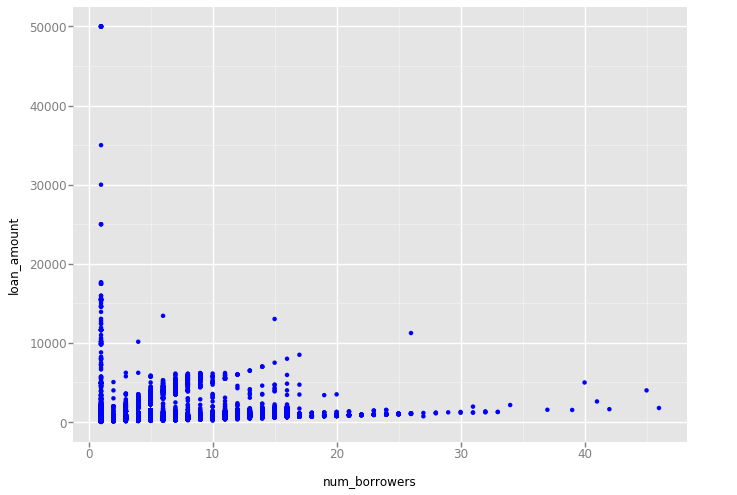

<ggplot: (-9223372036491397709)>

In [32]:
ggplot(df , aes(x = 'num_borrowers', y = 'loan_amount')) + geom_point(color = "blue") 

In [33]:
df[df['num_borrowers']>1]['loan_pc'].value_counts()

100.000000    623
75.000000     368
50.000000     311
450.000000    293
62.500000     274
300.000000    262
112.500000    234
200.000000    234
65.000000     179
66.666667     154
87.500000     152
500.000000    150
58.333333     139
68.750000     131
42.500000     126
56.250000     117
40.000000     116
81.250000     107
60.000000     106
95.000000     106
83.333333     102
93.750000      98
70.000000      94
67.857143      90
85.000000      89
250.000000     87
80.000000      87
64.285714      86
175.000000     84
150.000000     79
             ... 
642.857143      1
154.166667      1
538.636364      1
234.375000      1
891.666667      1
123.076923      1
596.428571      1
850.000000      1
868.333333      1
39.102564       1
733.333333      1
561.111111      1
131.818182      1
307.500000      1
857.142857      1
468.750000      1
854.166667      1
42.592593       1
779.166667      1
569.444444      1
310.000000      1
564.285714      1
236.538462      1
167.857143      1
765.000000

In [34]:
df[(df['num_borrowers']>1)&(df['loan_pc']==100)]['partner_id'].value_counts()

388.0    307
202.0    225
336.0     87
262.0      4
Name: partner_id, dtype: int64

In [35]:
df[(df['num_borrowers']>1)&(df['partner_id']==388)]['loan_pc'].describe()

count    1587.000000
mean      163.792289
std        60.980886
min        50.000000
25%       108.333333
50%       162.500000
75%       200.000000
max       300.000000
Name: loan_pc, dtype: float64

In [36]:
df.columns

Index(['activity', 'basket_amount', 'bonus_credit_eligibility', 'borrowers',
       'currency_exchange_loss_amount', 'description.languages',
       'description.texts.en', 'description.texts.es', 'description.texts.fr',
       'description.texts.ru', 'funded_amount', 'funded_date', 'id',
       'image.id', 'image.template_id', 'journal_totals.bulkEntries',
       'journal_totals.entries', 'lender_count', 'loan_amount',
       'location.country', 'location.country_code', 'location.geo.level',
       'location.geo.pairs', 'location.geo.type', 'location.town', 'name',
       'partner_id', 'payments', 'planned_expiration_date', 'posted_date',
       'sector', 'status', 'tags', 'terms.disbursal_amount',
       'terms.disbursal_currency', 'terms.disbursal_date', 'terms.loan_amount',
       'terms.local_payments', 'terms.loss_liability.currency_exchange',
       'terms.loss_liability.currency_exchange_coverage_rate',
       'terms.loss_liability.nonpayment', 'terms.repayment_interval',
     